In [30]:
library(tidyverse)

# Específico para el tamaño de plots en Jupyter:
set_plot_size <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

"1. Abra el archivo con R."

In [31]:
galton_raw <-
    read_csv('./Datos_sueltos/GaltonMod.csv') %>%
    select(parent, child)

galton_raw %>% head(4)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  X = col_integer(),
  parent = col_double(),
  child = col_double()
)


parent,child
70.5,61.7
68.5,61.7
65.5,61.7
64.5,400.0


"2. Proceda a graficar en un scatter plot las alturas de los padres y los hijos."

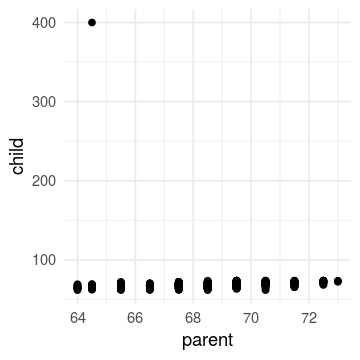

In [32]:
set_plot_size(3, 3)

galton_raw %>%
    ggplot() +
    aes(x = parent, y = child) +
    geom_point() +
    theme_minimal()

"3. Determine si se detactan anomalı́as y lleve a cabo la limpieza que considere prudente."

Vamos a quitar el outlier del scatter anterior, que es claramente un error.
Dado que los datos son alturas en pulgadas, filtramos con un umbral razonable
de valores de altura máxima esperada para una persona:

In [33]:
max_height = 100 # inches =~ 2.5 meters
galton <-
    galton_raw %>%
    filter(child < max_height & parent < max_height)

"Una vez hecho esto, nuevamente realice el scatter plot."

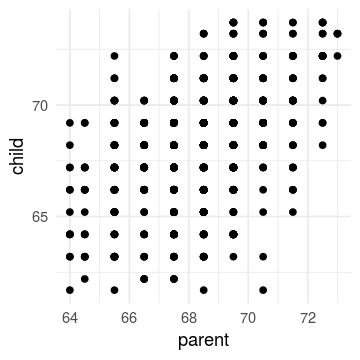

In [34]:
galton %>%
    ggplot() + 
    aes(x = parent, y = child) +
    geom_point() +
    theme_minimal()

**Observación**:

Tanto las alturas de los padres como de los hijos se reparten en valores discretos. Podría ser que los datos hayan estado sujetos a categorías de altura predefinidos.

In [35]:
galton %>% count(parent)

parent,n
64.0,14
64.5,22
65.5,66
66.5,78
67.5,211
68.5,219
69.5,183
70.5,68
71.5,43
72.5,19


In [36]:
galton %>% count(child)

child,n
61.7,4
62.2,7
63.2,32
64.2,59
65.2,48
66.2,117
67.2,138
68.2,120
69.2,167
70.2,99


Con todo, los decimales de altura de los hijos son particulares: .7 y .2. Tal vez fuera una limitación de los intrumentos de medición o una consecuencia de conversión entre unidades de medida.

Dado que las alturas de padres e hijos estan configuradas en valores específicos, el scatter es poco adecuado porque no se aprecia cuántos puntos se apilan en cada cruce de valores $(X, Y)$. Un heatmap será útil para ubicar regiones de más densidad de casos:

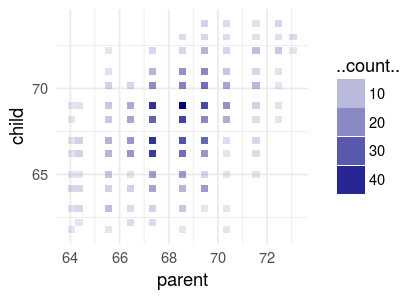

In [207]:
set_plot_size(3.5, 2.5)

galton %>%
    ggplot() +
    aes(x = parent, y = child, alpha = ..count..) +
    geom_bin2d(fill = 'Navy') +
    theme_minimal()

Otro modo de lograr lo mismo es la utilidad `geom_jitter` de `ggplot2`, que añade un poco de variación aleatoria a la ubicación de los puntos:

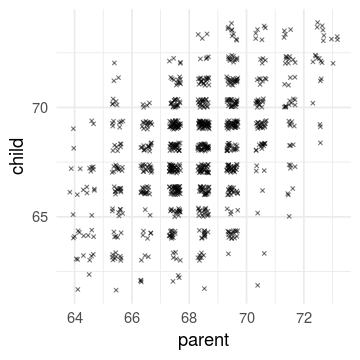

In [38]:
set_plot_size(3, 3)

galton %>%
    ggplot() + 
    aes(x = parent, y = child) +
    geom_jitter(size = 0.7, alpha = .5, shape = 4) +
    theme_minimal()

"4. Realice estudios de regresión lineal para determinar la relación entre la
altura de un padre y su hijo. Ensaye con diversos modelos (ejemplo,
lineal, cuadrático, entre otros), considere esquemas de training/testing
para seleccionar y utilice un criterio para poder concluir o aventurar el
tipo de relación entra ambas variables."

In [39]:
# Implementamos la regresión con las ecuaciones normales:
linear_regression <- function(x, y, grade) {
    columns <- c()
    for (exponent in 0:grade) {
        columns <- c(columns, x^exponent)
    }
    A <- matrix(columns, ncol = grade + 1)
    At_A <- t(A) %*% A
    At_y <- t(A) %*% y
    coefficients <- solve(At_A, At_y)
    list(
        coefficients = coefficients,
        y_estimated = A %*% coefficients
    )
}

Vamos a utilizar el método **K-fold** para elegir entre el modelo lineal y el cuadrático, según el que tenga menor error en promedio entre diferentes corridas.

In [112]:
make_folds <- function(x, k) {
    N <- length(x)
    fold_size <- ceiling(N/k)
    folds <- list()

    available_indices <- 1:N
    for (n in 1:k) {
        take_n <- min(length(available_indices), fold_size)
        fold <- sample(x = available_indices, size = take_n, replace = F)
        folds[[length(folds) + 1]] <- sort(fold)
        available_indices <- available_indices[! available_indices %in% fold]
    }
    folds
}

# NOTA: Esta función no anda bien cuando x tiene pocos elementos
# y length(x) no es múltiplo de k. Ej: make_folds(1:18, k = 7), queda
# el último fold vacío!

In [272]:
make_models <- function(train_data) {
    # train_data should have "y", "x" and "x_squared" columns
    list(
        'constante' = lm(y ~ 1, data = train_data),
        'lineal' = lm(y ~ 1 + x, data = train_data),
        'cuadrático' = lm(y ~ 1 + x + x_squared, data = train_data),
        'cúbico' = lm(y ~ 1 + x + x_squared + x_cubed, data = train_data)
    )
}

In [273]:
df <- tibble(
    x = galton$parent,
    x_squared = galton$parent^2,
    x_cubed = galton$parent^3,
    y = galton$child,
)

In [274]:
test_k_fold <- function(data, k_values) {
    errors <- NULL

    for (k in k_values) {   
        folds <- make_folds(x = data$x, k = k)

        for (i in seq_along(folds)) {
            data$test <- rownames(data) %in% folds[[i]]
            test_data <- data %>% filter(test)
            train_data <- data %>% filter(!test)

            models <- make_models(train_data)

            for (model_name in names(models)) {
                model <- models[[model_name]]
                y_estimated <- predict(model, test_data)    
                y_errors <- (test_data$y - y_estimated)^2
                mean_squared_error <- mean(y_errors)

                errors <- rbind(errors, tibble(
                    k = k,
                    test_fold = i,
                    model = model_name,
                    mean_error_2 = mean(y_errors),
                ))
            }
        }
    }
    errors    
}

errors <- test_k_fold(df, k_values = 3:100)
errors %>% head(5)

k,test_fold,model,mean_error_2
3,1,constante,6.734746
3,1,lineal,5.235758
3,1,cuadrático,5.279971
3,1,cúbico,5.290567
3,2,constante,6.136117


Consideramos modelo ganador al lineal, dado que los modelos cuadrático y cúbico no parecen reducir el error de modo interesante:

Warning message:
“Removed 402 rows containing non-finite values (stat_boxplot).”

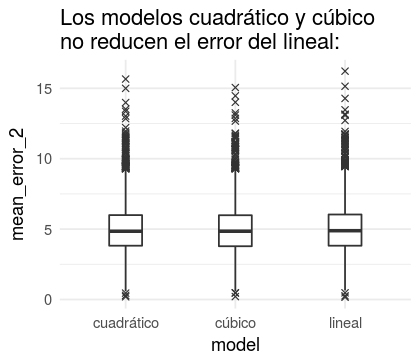

In [350]:
set_plot_size(3.5, 3)

errors %>%
    filter(model != 'constante') %>%
    ggplot() +
    aes(x = model, y = mean_error_2) +
    geom_boxplot(width = 0.3, outlier.shape = 4) +
    labs(title = 'Los modelos cuadrático y cúbico\nno reducen el error del lineal:') +
    # ylim(2, 7) +
    theme_minimal()

**Observación:**

La dispersión del error cuadrado medio aumenta a medida que el valor de $k$ crece. Sin embargo, el error cuadrado medio se mantiene.

Warning message:
“Removed 134 rows containing missing values (geom_point).”

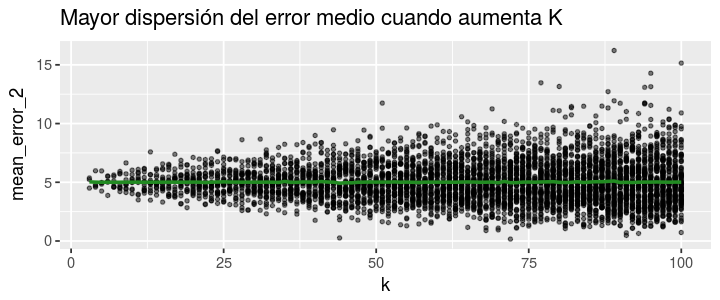

In [396]:
set_plot_size(6, 2.5)

mean_error_by_k_in_linear_model <-
    errors %>%
    filter(model == 'lineal') %>%
    group_by(k) %>%
    na.omit %>%
    summarise(mse = mean(mean_error_2))

errors %>%
    # Hide the "constant" model because it's far worse than the others
    filter(model == 'lineal') %>%
    ggplot() +
    aes(x = k, y = mean_error_2) +
    geom_point(shape = 20, alpha = .5) +
    labs(title = 'Mayor dispersión del error medio cuando aumenta K') +
    geom_line(
        data = mean_error_by_k_in_linear_model,
        aes(x = k, y = mse),
        color = 'ForestGreen',
        size = 1
    )

"5. Grafique el scatter plot de los datos junto con una curva representando el
modelo escogido en el inciso anterior. Haga el gráfico de la curva en una
grilla fina, de resolución menor o igual a $0.01$."

NOTA: $0.01$ de resolución es demasiado fino, no queda bien para los datos del trabajo. Lo cambié a $0.1$.

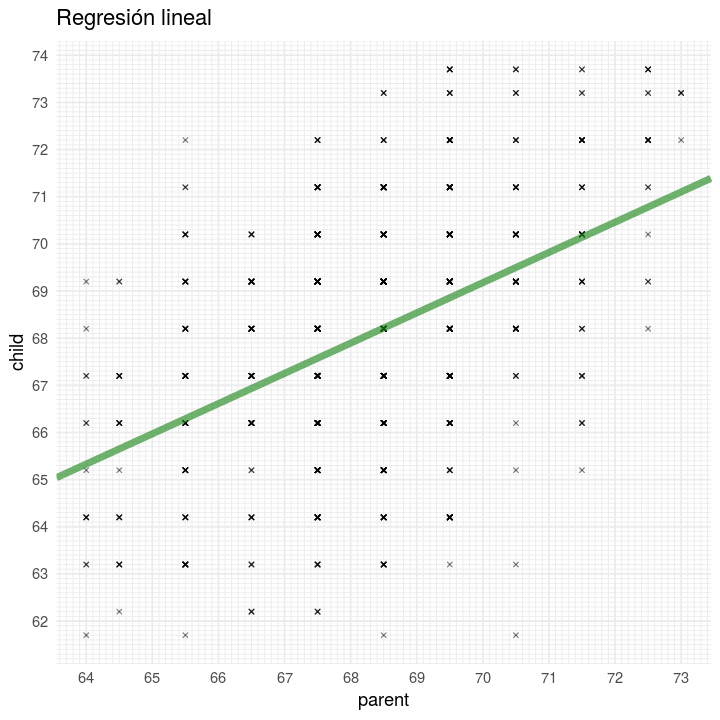

In [367]:
regression <- lm(child ~ 1 + parent, data = galton)

set_plot_size(6, 6)

galton %>%
    ggplot() +
#     geom_jitter(
    geom_point(
        aes(x = parent, y = child),
        shape = 4,
        size = 1,
        alpha = .5,
    ) +
    geom_abline(
        intercept = regression$coefficients[[1]],
        slope = regression$coefficients[[2]],
        color = 'ForestGreen',
        size = 2,
        alpha = .65
    ) +
    labs(title = 'Regresión lineal') +
    theme_minimal() +
    scale_y_continuous(
        minor_breaks = seq(0 , 100, 0.1),
        breaks = seq(0, 100, 1)
    ) +
    scale_x_continuous(
        minor_breaks = seq(0 , 100, 0.1),
        breaks = seq(0, 100, 1)
    )